# Beer Reviews
### Michael Frasco

In [1]:
import json
import string
import numpy as np
from pyspark.mllib.feature import HashingTF, IDF, Normalizer
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import SparseVector
import string
from pyspark.mllib.tree import DecisionTree, RandomForest, GradientBoostedTrees
import matplotlib.pyplot as plt
% matplotlib inline
import matplotlib.patches as mpatches

In [2]:
all_reviews = sc.textFile("s3n://stat-37601/ratings.json",
                          minPartitions=100,
                          use_unicode=False).map(json.loads)

In [8]:
def GetLabel(review):
    # Get the overall rating from a review
    
    label, total = review["review_overall"].split("/")
    return float(label) / float(total)

In [9]:
labels = all_reviews.map(GetLabel)

##### Generating Features

In [11]:
def AddAdverb(features):
    # input: a list of features
    # output: a new list of features with "not" and "happy"
        # combined as "not_happy"
    
    adverb_list = ['not', 'really', 'very']
    new_features = []
    not_indicator = False
    for i in range(len(features)-1):
        if not_indicator:
            not_indicator = False
            continue
        if features[i] in adverb_list:
            ad_word = features[i] + "_" + features[i+1]
            new_features.append(ad_word)
            not_indicator = True
        else:
            new_features.append(features[i])
    return new_features

In [12]:
stop_words = ['a','able','about','across','after','all','almost','also','am',
             'among','an','and','any','are','as','at','be','because','been',
             'but','by','can','cannot','could','dear','did','do','does',
             'either','else','ever','every','for','from','get','got','had',
             'has','have','he','her','hers','him','his','how','however','i',
             'if','in','into','is','it','its','just','least','let','like',
             'likely','may','me','might','most','must','my','neither','no',
             'nor','not','of','off','often','on','only','or','other','our',
             'own','rather','said','say','says','she','should','since','so',
             'some','than','that','the','their','them','then','there','these',
             'they','this','tis','to','too','twas','us','wants','was','we',
             'were','what','when','where','which','while','who','whom','why',
             'will','with','would','yet','you','your']

In [13]:
def RemoveStopWords(features):
    return [word for word in features if word not in stop_words]

In [14]:
def ParseReview(review):
    # input: a string of text
    # output: all lowercase, no punctuation, removed stopwords,
        # and added basic adverbs bigrams
    
    review = review.encode('ascii', 'ignore')
    review = review.lower()
    review = review.translate(string.maketrans("",""), string.punctuation)
    features = review.split(" ")
    features = [t for t in features if t != '']
    features = AddAdverb(features)
    return RemoveStopWords(features)

In [15]:
review_features = all_reviews.map(lambda x: ParseReview(x['review_text']))

Memory issues were a big problem for this assignment. Below, I set the number of features in the hashingTF function to only 50. This will result in a number of collisions, to be sure. And while this may decrease my performance. It makes my life a lot easier.

In [16]:
hashingTF = HashingTF(50)
tf = hashingTF.transform(review_features)

In [17]:
idf = IDF().fit(tf)
tfidf = idf.transform(tf)

In [18]:
nor = Normalizer(p=2.0)
features = nor.transform(tfidf)

In [20]:
data = features.zip(labels).map(lambda (feature, label): LabeledPoint(label, feature))
train_data, test_data = data.randomSplit([0.7, 0.3], 6)

In the code above I set up my data in LabeledPoint format. Then I split the data into training and testing sets, so that I can test how well my models are performing on unseen data.

##### Regression Model and Evaluation

In [25]:
def MSE(model, data_set):
    # input: a model and a data set, either training or testing
    # output: the mean square error for the model
    
    preds = model.predict(data_set.map(lambda x: x.features))
    labels_preds = data_set.map(lambda x: x.label).zip(preds)
    return labels_preds.map(lambda (l, p): (l - p) * (l - p)).mean()

### Building Models

##### Decision Trees

In [26]:
model = None

In [27]:
depths = [2, 4, 6, 8]
train_errors = []
test_errors = []
for d in depths:
    model = DecisionTree.trainRegressor(train_data, {}, maxDepth=d)
    train_errors.append(MSE(model, train_data))
    test_errors.append(MSE(model, test_data))
    model = None

In [28]:
train_errors

[0.026813982991465958,
 0.026241185370343856,
 0.025758857740006334,
 0.02521583128440416]

In [29]:
test_errors

[0.027081732341664617,
 0.026496181198606323,
 0.026122817733682125,
 0.025992540472513505]

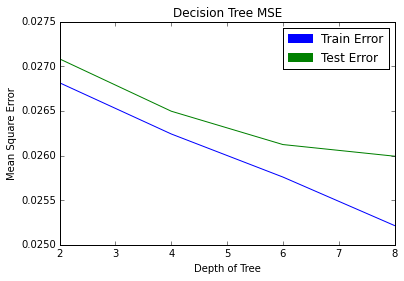

In [36]:
plt.plot(depths, train_errors)
plt.plot(depths, test_errors)
plt.title("Decision Tree MSE")
plt.xlabel("Depth of Tree")
plt.ylabel("Mean Square Error")
blue_patch = mpatches.Patch(color='blue', label='Train Error')
green_patch = mpatches.Patch(color='green', label='Test Error')
plt.legend(handles=[blue_patch, green_patch])
plt.show()

I would keep increasing the size of the tree, but if I go any further, I run out of space on my computer. Fortunately, it looks like the test error is starting to level out at a depth of eight, so maybe building deeper wouldn't be any better.

##### Random Forest

In [46]:
num_trees = [5, 10, 15, 20]
train_errors = []
test_errors = []
for n in num_trees:
    model = RandomForest.trainRegressor(train_data, {}, numTrees=n,
                                        featureSubsetStrategy="onethird",
                                        maxDepth=8)
    train_errors.append(MSE(model, train_data))
    test_errors.append(MSE(model, test_data))
    model = None

In [47]:
train_errors

[0.024959429244088584,
 0.02484604830882508,
 0.024823854676263194,
 0.024807463859298013]

In [48]:
test_errors

[0.025595207807760093,
 0.025484747306036486,
 0.02545513403433832,
 0.025438430962625845]

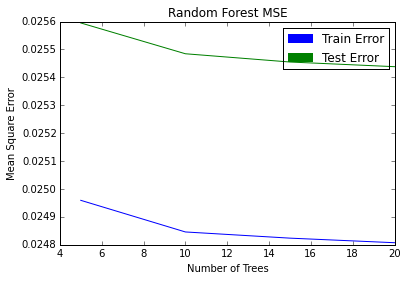

In [49]:
plt.plot(num_trees, train_errors)
plt.plot(num_trees, test_errors)
plt.title("Random Forest MSE")
plt.xlabel("Number of Trees")
plt.ylabel("Mean Square Error")
blue_patch = mpatches.Patch(color='blue', label='Train Error')
green_patch = mpatches.Patch(color='green', label='Test Error')
plt.legend(handles=[blue_patch, green_patch])
plt.show()

I found that when using trees that were four levels deep (i.e. maxDepth=4), the training error and testing error achieved a minimum value at 15 trees. The minimum training error was 0.026 and the minimum testting error was 0.02625. Decreasing the depth gave worse results, as we would expect. The minimum training error was 0.027 and the minimum testing error was 0.0274. Lastly, I increased the depth of the trees to 8 levels. I attained the best results, which are plotted above. Since a random forest is a collection of decision trees, we would expect them to perform better than just a single tree. This expectation is confirmed in the plot above. However, notice that when using a depth of eight layers, adding more trees does not improve our accuracy by a whole lot.

##### Gradient Boosted Trees

In [57]:
num_iterations = [10, 50, 100, 150, 200]
train_errors = []
test_errors = []
for n in num_iterations:
    model = GradientBoostedTrees.trainRegressor(train_data, {}, numIterations=n,
                                                loss="leastSquaresError", learningRate=0.1,
                                                maxDepth=1)
    train_errors.append(MSE(model, train_data))
    test_errors.append(MSE(model, test_data))
    model = None

In [58]:
train_errors

[0.026587973128055272,
 0.02550132359452694,
 0.025159009324405276,
 0.02498669759407325,
 0.024876207822390313]

In [59]:
test_errors

[0.02682305736889885,
 0.02571826667398105,
 0.025384343272857313,
 0.02522092865818351,
 0.02512046520186902]

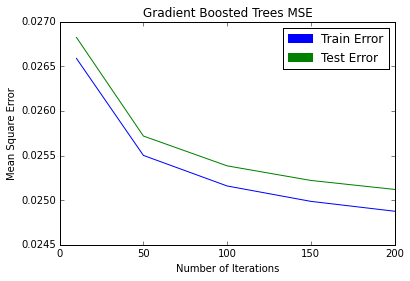

In [60]:
plt.plot(num_iterations, train_errors)
plt.plot(num_iterations, test_errors)
plt.title("Gradient Boosted Trees MSE")
plt.xlabel("Number of Iterations")
plt.ylabel("Mean Square Error")
blue_patch = mpatches.Patch(color='blue', label='Train Error')
green_patch = mpatches.Patch(color='green', label='Test Error')
plt.legend(handles=[blue_patch, green_patch])
plt.show()

Gradient boosted trees perform the best on the test set. The error is only slightly higher than the error on the training data. Also, I experimented with the logLoss error and experienced MSE values that were greater than 1. With a learning rate of 0.1, 100 iterations of trees with maxDepth=1, I achieved a MSE of 0.0251 and 0.0253. With 200 iterations, the MSE were 0.0248 and 0.0251.

In [61]:
learning_rates = [0.01, 0.1, 0.25, 0.5]
train_errors = []
test_errors = []
for r in learning_rates:
    model = GradientBoostedTrees.trainRegressor(train_data, {}, numIterations=100,
                                                loss="leastSquaresError", learningRate=r,
                                                maxDepth=1)
    train_errors.append(MSE(model, train_data))
    test_errors.append(MSE(model, test_data))
    model = None

In [62]:
train_errors

[0.026473537055041373,
 0.02516085081792289,
 0.024810651196115977,
 0.024752303673294264]

In [63]:
test_errors

[0.026711804135058147,
 0.025384240700215503,
 0.025061505510461345,
 0.025020486578265642]

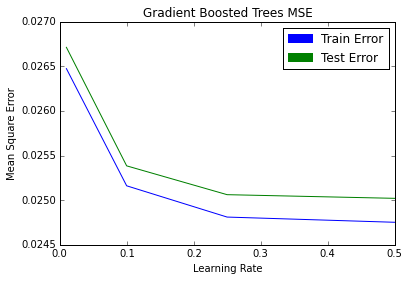

In [64]:
plt.plot(learning_rates, train_errors)
plt.plot(learning_rates, test_errors)
plt.title("Gradient Boosted Trees MSE")
plt.xlabel("Learning Rate")
plt.ylabel("Mean Square Error")
blue_patch = mpatches.Patch(color='blue', label='Train Error')
green_patch = mpatches.Patch(color='green', label='Test Error')
plt.legend(handles=[blue_patch, green_patch])
plt.show()

I found that the default learning rate of 0.1 does not minimize the training or testing errors. A learning rate of 0.25 does better.

In [ ]:
max_depths = [1, 2, 3]
train_errors = []
test_errors = []
for d in max_depths:
    model = GradientBoostedTrees.trainRegressor(train_data, {}, numIterations=100,
                                                loss="leastSquaresError", learningRate=0.25,
                                                maxDepth=d)
    train_errors.append(MSE(model, train_data))
    test_errors.append(MSE(model, test_data))
    model = None

In [66]:
d

3

In [67]:
train_errors

[0.024809368272328776, 0.02440682664817677, 0.023925199821137534]

In [68]:
test_errors

[0.02505725989674417, 0.024797678927877195, 0.024595650815203412]

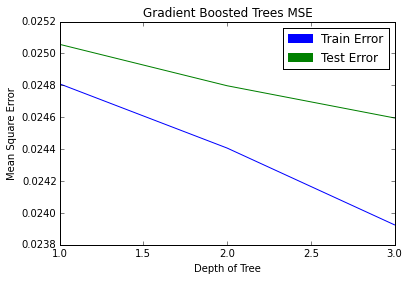

In [69]:
plt.plot(max_depths, train_errors)
plt.plot(max_depths, test_errors)
plt.title("Gradient Boosted Trees MSE")
plt.xlabel("Depth of Tree")
plt.ylabel("Mean Square Error")
blue_patch = mpatches.Patch(color='blue', label='Train Error')
green_patch = mpatches.Patch(color='green', label='Test Error')
plt.legend(handles=[blue_patch, green_patch])
plt.show()

The default size of the trees is three levels. After the lecture in class, I figured that was too big of a tree, so I started working with 1 level trees, which also saved time. However, the plot above shows that trees with three levels perform the best so far.